In [1]:
# Many of those is based on Andrej Karpathy blog

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

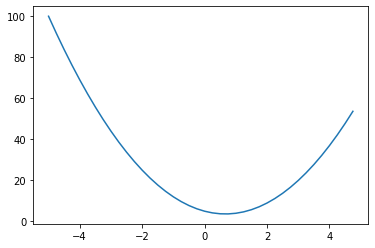

In [6]:
plt.plot(xs, ys)

In [7]:
# Let's try out calculate derivative of our f function with small h

In [8]:
h = 0.000001
x = 2/3
f(x)

3.666666666666667

In [9]:
(f(x+h)-f(x))/h

2.999378523327323e-06

More complex function

In [10]:
h = 0.000001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.000001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.000000999999999
slope 0.9999999992515995


In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def tanh(self):
        x = self.data
        t = math.tanh(x)
        def _backward():
            self.grad += (1-math.tanh(x)**2) * out.grad
        
        out = Value(t, (self, ), 'tanh')
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [14]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
d._op

'+'

Visually tracing derivitave calc

In [16]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    nodes, edges = trace(root)
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad,), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

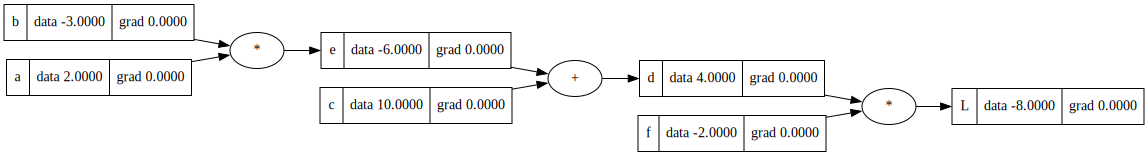

In [17]:
draw_dot(L)

In [18]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [19]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

-4.000000000008441


In [20]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias
b = Value(6.88130, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

In [32]:
draw_dot(n)

AttributeError: 'MLP' object has no attribute '_prev'

In [22]:
o.backward()

In [23]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# o.grad = 1.0
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# w2.grad = x2.data *x2w2.grad
# x2.grad = w2.data *x2w2.grad
# w1.grad = x1.data *x1w1.grad
# x1.grad = w1.data *x1w1.grad

In [31]:
class Neuron:
    def __init__(self, nin):
        # define random weight (using random.uniform)
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]       
        # define random bias (-1,1)
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self, x):
        # x*w+b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, ninp, nout):
        self.neurons = [Neuron(ninp) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
    
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n(x)
n = MLP(3, [4,4,1])
n(x)

[Value(data=-0.3477049062734245)]